In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [2]:
class Customer: # Customer Energy Management with Peak Shaving Strategy
    def __init__(self,hh_demand,pvsize,hh_SOC,batt_size,Pr_grid,fit):
        self.hh_demand=hh_demand
        self.hh_gen=Pg.iloc[t].values*pvsize
        self.hh_SOC=hh_SOC
        self.batt_size=batt_size
        self.Pr_fit=fit
        self.Pr_grid=Pr_grid
        self.E=batt_size
        self.Pbmax=batt_size*Crate
        self.window_size = window_size
        self.hh_demand = self.price_responsive_load()
        
        self.avg_net_load=self.sliding_average_load()

        if self.batt_size>0: #battery management
            self.battery=self.sliding_average_battery_management()
            self.Pgrid=self.battery[0]
            self.SOC2=self.battery[1]
            self.Pb=self.battery[2]
        else: #Energy management in absence of battery

            self.Pgrid=(self.hh_demand-self.hh_gen)
            self.SOC2=0
            self.Pb=0

    def price_responsive_load(self):
        if self.Pr_grid >= Pr_th_s:
            self.hh_demand = 0.5 * self.hh_demand + 0.5 * self.hh_demand * math.exp(-8 * (Pr_th_s - Pr_th_b))
        elif self.Pr_grid >= Pr_th_b and self.Pr_grid <= Pr_th_s:
            self.hh_demand = 0.5 * self.hh_demand + 0.5 * self.hh_demand * math.exp(-8 * (self.Pr_grid - Pr_th_b))
        else:
            self.hh_demand = 0.5 * self.hh_demand + 0.5 * self.hh_demand * math.exp(-8 * (Pr_th_b - Pr_th_b))
        return self.hh_demand

    def sliding_average_load(self):

        self.net_load = self.hh_demand - self.hh_gen
        
        if len(net_load_history) > self.window_size:
            net_load_history.pop(0)  

        if len(net_load_history) == self.window_size:
            self.avg_net_load = np.mean(net_load_history)
        else:
            self.avg_net_load = self.net_load  
        
        net_load_history.append(self.net_load)

        return self.avg_net_load

    def sliding_average_battery_management(self):

        self.net_load = self.hh_demand - self.hh_gen

        # Battery charging/discharging based on sliding average net load
        if self.net_load > self.avg_net_load:
            Pb_cal = (self.hh_SOC - SOC_min) * (self.E * nd) / dT  
            self.Pb = -min(self.net_load-self.avg_net_load, self.Pbmax)
        elif self.net_load < self.avg_net_load:
            Pb_cal = (SOC_max - self.hh_SOC) * self.E * nc / dT 
            self.Pb = min(self.avg_net_load-self.net_load, self.Pbmax)
        else:
            self.Pb = 0  

        self.Pgrid = (self.hh_demand - self.hh_gen) + self.Pb

        self.SOCend = self.hh_SOC + ((self.Pb * nc) * (dT / self.E) if self.Pb >= 0 else (self.Pb / nd) * (dT / self.E))

        return self.Pgrid, self.SOCend, self.Pb


In [3]:
class CustomerOffgrid:
    def __init__(self,hh_demand,pvsize,hh_SOC,batt_size):
        self.hh_demand=hh_demand
        self.hh_gen=Pg.iloc[t].values*pvsize
        self.hh_SOC=hh_SOC
        self.batt_size=batt_size
        self.E=batt_size
        self.Pbmax=batt_size*Crate
        self.battery=self.battery_management()
        self.Pb=self.battery[0]
        self.SOC2=self.battery[1]
        self.Pcurtail=self.battery[2]

    def battery_management(self):
        if self.hh_gen>self.hh_demand:
            self.Pbcal=(SOC_max-self.hh_SOC)*self.E/(nc*dT) #Charging
            if self.Pbcal>=self.Pbmax:
                self.Pbreq=self.Pbmax
            else:
                self.Pbreq=self.Pbcal
            if (self.hh_gen-self.hh_demand)>=self.Pbreq:
                self.Pb=self.Pbreq 
            else:
                self.Pb=(self.hh_gen-self.hh_demand)
        else:
            self.Pbcal=(self.hh_SOC-SOC_min)*(nd*self.E)/dT
            if self.Pbcal>=self.Pbmax:
                self.Pbav=self.Pbmax
            else:
                self.Pbav=self.Pbcal
            if (self.hh_demand-self.hh_gen)>=self.Pbav:
                self.Pb=-self.Pbav
            else:
                self.Pb=-(self.hh_demand-self.hh_gen) #discharge is -ve Pb
        self.Pcurtail=self.hh_demand-self.hh_gen+self.Pb
        self.SOCend=self.hh_SOC + ((self.Pb*nc)*(dT/self.E) if self.Pb>=0 else (self.Pb/nd)*(dT/self.E))
        return self.Pb, self.SOCend, self.Pcurtail

In [4]:
class LCOEoff:
    def __init__(self,SystemCost):
        self.SystemCost=SystemCost
        self.lcoeoff=self.calculate_lcoeoff()
        
    def calculate_lcoeoff(self):
        self.lcoeoff=((self.SystemCost) + (Inv[k-1]*10/15 if k>=1 else 0) + (Inv[k-2]*5/15 if k>=2 else 0))/(Pd.iloc[h,:].sum()*15)
        return self.lcoeoff

##### Object to calculate hourly bill of individual customer

In [5]:
class Bill:
    def __init__(self,peakdemand,tierrate,peaktier):
        self.peakdemand=peakdemand
        self.tierrate=tierrate
        self.peaktier=peaktier
        self.tiers=np.zeros(12)
        self.electricity_bill=self.calculate_electricity_bill()
        self.o=0
    def calculate_electricity_bill(self):
        bill=[]
        k=0    
        for i in range(num_periods):
            for j in range(3):  
                self.o=i+j
                if self.peakdemand.iloc[self.o] <= self.peaktier.iloc[i, 0]:
                    billmonth = self.tierrate.iloc[0, i] * 30
                elif self.peakdemand.iloc[self.o] <= self.peaktier.iloc[i, 1]:
                    billmonth = self.tierrate.iloc[1, i] * 30
                elif self.peakdemand.iloc[self.o] <= self.peaktier.iloc[i, 2]:
                    billmonth = self.tierrate.iloc[2, i] * 30
                else:
                    billmonth = self.tierrate.iloc[3, i] * 30
                bill.append(billmonth)
                k=k+1
        return np.sum(bill)    

In [6]:
class Billexp:
    def __init__(self,peakdemand,tierrate,peaktier):
        self.peakdemand=peakdemand
        self.tierrate=tierrate
        self.peaktier=peaktier
        self.tiers=np.zeros(12)
        self.electricity_bill=self.calculate_electricity_bill()

    def calculate_electricity_bill(self):
        bill=[]
        k=0
        for i in range(num_periods):
            for j in range(0,3):
                billseason=(self.tierrate.iloc[0,i]*30 if peakdf[h,k] <= self.peaktier.iloc[i,0] else self.tierrate.iloc[1,i]*30 if peakdf[h,k] <= self.peaktier.iloc[i,1] else self.tierrate.iloc[2,i]*30 if peakdf[h,k] <= self.peaktier.iloc[i,2] else self.tierrate.iloc[3,i]*30)
                bill.append(billseason)
                k=k+1
        return np.sum(bill)   

In [7]:
class Systemsize:
    def __init__(self,total_energy_consumption):
        self.total_energy_consumption=total_energy_consumption
        self.maxlimitpv=1
        panelsize=0.4 #kW
        annual_om_cost_per_kw=OnM.iloc[k*5]
        BattCost=Batteryadvanced.iloc[k*5]
        PVCost=PVadvanced.iloc[k*5]

        X2=self.maxlimitpv*self.total_energy_consumption/(solar_prod_annual)
        X=X2-(pvk[k-1,h] if k>=1 else 0)-(pvk[k-2,h] if k>=2 else 0)
        X1=math.ceil(X/panelsize) #number of 0.4 kW PV panels

        #PV size options: 100%, 50%, 25%, 0
        PV1=X1*panelsize 
        PV2=math.floor(X1/2)*panelsize
        PV3= math.floor(X1/4)*panelsize
        PV4=0
        data_PV = {'PVSize': [PV1, PV2, PV3, PV4],
                  'PVCost': [PVCost*PV1, PVCost*PV2, PVCost*PV3, PVCost*PV4]}
        df_PV = pd.DataFrame(data_PV)
        
        #Battery size options: round down values, closest to selected PV sizes
        B1=math.floor(PV1)/Crate
        B2=math.floor(PV2)/Crate
        B3=math.floor(PV3)/Crate
        B4=math.floor(PV4)/Crate
        data_B = {'BattSize': [B1, B2, B3, B4],
                  'BattCost': [BattCost*B1, BattCost*B2, BattCost*B3, 0]} #price of battery
        df_B = pd.DataFrame(data_B)  
       
        self.df_combinations = pd.DataFrame(columns=['PVSize', 'BattSize', 'Total_Cost']) 

        for _, row_PV in df_PV.iterrows():
            for _, row_B in df_B.iterrows():
                total_cost = row_PV['PVCost'] + row_B['BattCost'] + annual_om_cost_per_kw*row_PV['PVSize']*systemlifetime
                data = [[row_PV['PVSize'], row_B['BattSize'], total_cost]]
                self.df_combinations = pd.concat([self.df_combinations, pd.DataFrame(data, columns=['PVSize', 'BattSize', 'Total_Cost'])])

        self.df_combinations.reset_index(drop=True, inplace=True)  # Reset the index
        print(self.df_combinations)

##### Object for individual customer's decision

In [8]:
class Decision:
    def __init__(self,Electricity_Bill,PVSizedecision,BattSizedecision,SystemCost,Loff):
        self.electricity_bill=Electricity_Bill
        self.PVSizedecision=PVSizedecision
        self.BattSizedecision=BattSizedecision
        self.SystemCost=SystemCost
        self.options=options
        self.Loff=Loff

        self.LCOE=np.zeros(self.options)

        self.lcoge=self.calculate_lcoge() #levelized cost of grid electricity
        self.PV_lcoe=self.calculate_PV_lcoe() #levelized cost of each PV-batt combination
        self.system_decision=self.select_system() #logic to select one combination

    def calculate_lcoge(self): #previous investment?
        self.lcoge = round((Inv[k-2,h]*5/15 + Inv[k-1,h]*10/15 + Billexpected[k,h]*5 + Billkminus1k[h,15]*5 + (Bill0[k,h]*5))/(Pd.iloc[h,:].sum()*15) if k>=2 else (Inv[k-1,h]*10/15 + (Billexpected[k,h]*10) + Bill0[k,h]*5)/(Pd.iloc[h,:].sum()*15) if k==1 else (Bill0[k,h]*15)/(Pd.iloc[h,:].sum()*15),3)
        print('grid lcoe',self.lcoge)
        return self.lcoge
    
    def calculate_PV_lcoe(self):
        for i in range(0,self.options):
            self.LCOE[i]=round((Inv[k-2,h]*5/15+Inv[k-1,h]*10/15+EFCO*self.SystemCost[i]+(self.electricity_bill[i])*5+Billkminus1k[h,i]*5+Billonlyk[h,i]*5)/(Pd.iloc[h,:].sum()*15) if (k-2) >= 0 else (Inv[k-1,h]*10/15+EFCO*self.SystemCost[i]+(self.electricity_bill[i])*10+Billonlyk[h,i]*5)/(Pd.iloc[h,:].sum()*15) if k==1 else (EFCO*self.SystemCost[i] + (self.electricity_bill[i])*15)/(Pd.iloc[h,:].sum()*15),3)
        return(self.LCOE)

    def select_system(self):
        print('LCOE combinations',self.LCOE)

        self.L= np.append(self.LCOE, self.Loff)
        self.PV_add_lcoe=min(filter(lambda y: y <= self.lcoge+1, self.L), default=None)
        index = np.where(self.L==self.PV_add_lcoe)[0]
        self.index = index[0]
        self.Selected_PV=self.PVSizedecision[self.index]
        self.SelectedBatt=self.BattSizedecision[self.index]
        print('selected',self.L[self.index])
        print('selected PV size', self.Selected_PV)
        print('selected Batt size', self.SelectedBatt)
        return self.PV_add_lcoe

##### Object for Retailer Cost Calculation- Peak Charges

In [9]:
#Business-as-usual
#Object for retailer energy-related and fixed-costs
class Energy_costs: 
    def __init__(self,TotalLoad1,cont_vol,cont_price,WS_price,ret_margin_E,ret_margin_NE,risk_margin,admin_ch,fees,dvc,hourlynet,netresload,hourly_load,hourly_ugen,HourlyResLoad,connectedhouses):
        #Energy Procurement variables
        self.cont_vol=cont_vol #contract volume
        self.cont_price=cont_price #contract price
        self.total_load=TotalLoad1
        #Variable cost components
        self.ret_margin_E=ret_margin_E #energy return margin
        self.ret_margin_NE=ret_margin_NE #return margin on non-energy costs
        self.risk_margin=risk_margin
        self.dvc=dvc
        #Fixed cost components
        self.hourlynetload=hourlynet
        self.hourly_load=hourly_load
        self.hourly_ugen=hourly_ugen
        self.resload=HourlyResLoad
        self.netresload=netresload
        self.no_of_HH=connectedhouses

        self.energy_proc_cost=self.calculate_energy_proc_cost()
        self.Ret_Var_Cost_pu=self.calculate_Ret_Var_Cost_pu()
        self.ret_fixed_cost=self.calculate_ret_fixed_cost()
        self.ret_fixed_cost_HH=self.calculate_ret_fixed_cost_HH()
        self.ret_rev=self.calculate_ret_rev()
        self.rate=self.calculate_rate()
        self.dsocharges=self.calculate_chargestoDSO()
 
    def calculate_energy_proc_cost(self): #energy procurment costs from contracts and WS markets
        epcost=(WS_price*np.maximum(0,(self.hourlynetload-cont_vol))+cont_vol*cont_price).sum(axis=1)
        print('market cost', (WS_price*np.maximum(0,(self.hourlynetload-cont_vol))).values.sum())
        print('cont cost', (cont_vol*cont_price).values.sum())               
        return epcost
    
    def calculate_Ret_Var_Cost_pu(self): #retailer's total variable costs
        print('EP cost', (self.energy_proc_cost.sum())*(1+self.ret_margin_E+self.risk_margin))
        print('load', (self.hourlynetload.values.sum()))
        self.rvc=((self.energy_proc_cost)*(1+self.ret_margin_E+self.risk_margin)/(self.hourly_load.sum(axis=1)))
        return self.rvc
    
    def calculate_ret_fixed_cost(self): #retailer's total fixed costs per hour over 15 years
        return (admin_ch)*(1+ret_margin_NE)
      
    def calculate_ret_fixed_cost_HH(self): #fixed costs per household: 
        return (self.ret_fixed_cost/(5*households.sum(axis=1)*8760)) #per hour charge
    
    def calculate_ret_rev(self):
         return ((self.Ret_Var_Cost_pu*base.sum(axis=1)*1000).sum())

    def calculate_rate(self):
        self.rates=np.zeros((num_periods))
        self.tierrate=pd.DataFrame()
        # Same Tierate as Energy Arbitrage Case for Comprison
        if k ==0:
            self.rates = [2.854208, 2.344402, 2.684119, 2.579578]
            self.tierrate = pd.DataFrame([
            [2.854208, 2.344402, 2.684119, 2.579578],
            [4.281311, 3.516603, 4.026178, 3.869367],
            [6.421967, 5.274905, 6.039267, 5.804050],
            [9.276174, 7.619307, 8.723385, 8.383628]
            ])
            
            self.tierrate = 0.9*self.tierrate
            
        elif k == 1:
            self.rates = [2.74026051, 2.32317996, 2.65326688, 2.60754017]
            self.tierrate = pd.DataFrame([
            [2.740261,  2.32318,   2.653267,  2.60754 ],
            [4.110391,  3.48477,   3.9799,    3.91131 ],
            [6.165586,  5.227155,  5.96985,   5.866965],
            [8.905847,  7.550335,  8.623117,  8.474506]
            ])

            self.tierrate = 0.9*self.tierrate

        elif k == 2:
            self.rates = [2.60852228, 2.13424574, 2.5473767,  2.48984479]
            self.tierrate = pd.DataFrame([
            [2.608522, 2.134246, 2.547377, 2.489845],
            [3.912783, 3.201369, 3.821065, 3.734767],
            [5.869175, 4.802053, 5.731598, 5.602151],
            [8.477697, 6.936299, 8.278974, 8.091996]
            ])

            self.tierrate = 0.9*self.tierrate    

        for i in range(num_periods):
            self.seasonalload_del = pd.DataFrame()
            self.seasonalload_ret = pd.DataFrame()
            start_idx = i * 2190
            end_idx = (i + 1) * 2190 if i < num_periods - 1 else len(loads1)
            self.seasonalload_del = (self.resload.sum(axis=1)[start_idx:end_idx].reset_index(drop=True))
            self.seasonalload_ret = (self.netresload.sum(axis=1)[start_idx:end_idx].reset_index(drop=True))
            self.rvcseasonal = self.rvc[start_idx:end_idx].reset_index(drop=True)

        print('tierrate', self.tierrate)
        print('rate', self.rates)
        
    def calculate_chargestoDSO(self):
        dsocharges=((self.dvc)*self.resload.sum(axis=1)).sum()+Fixed_connection_charges
        return dsocharges

##### Object for Delivery Cost Calculation

In [10]:
class Delivery_Costs:
    def __init__(self,total_load,h):
        #margin included in these costs
        self.Fixed_connection_charges=Fixed_connection_charges #fixed distribution connection charges
        self.total_load=total_load
        self.no_of_HH=h
        self.T_cost=self.calculate_T_cost()
        self.D_cost=self.calculate_D_cost()
        self.M_cost=self.calculate_M_cost()
        self.dist_var_cost_pu=self.calculate_dist_var_cost_pu()
        self.dist_fixed_cost_HH=self.calculate_dist_fixed_cost_HH()

    def calculate_T_cost(self):
        return Tcost
    
    def calculate_D_cost(self):
        return Dcost
    
    def calculate_M_cost(self):
        return Mcost
    
    def calculate_dist_var_cost_pu(self): #variable costs per kWh
        return (Tcost+Dcost+Mcost)
    
    def calculate_dist_fixed_cost_HH(self): #fixed costs per house
        return (self.Fixed_connection_charges/(5*households.values.sum()*8760))

In [11]:
EFCO=1
window_size=6

kmax=3
houses=5
totalhouses=321900.6
yy=0
yyend=15
cagr=0.016
cagrhouses=0.02
planninghorizon=yyend-yy
hours=8760
cont_price=0.15
ret_margin_E=0.15
ret_margin_NE=0.05
risk_margin=0.05
Tcost=0.042094
Dcost=0.013033
Mcost=0.017162
Fixed_connection_charges=0.647903*365*planninghorizon*totalhouses*5
Other_ch=0
rate_riders=0 #enter the values as $/h 
admin_ch=0.2392*totalhouses*5*365*planninghorizon
fees=0
SOC_min=0.10
SOC_max=1
Crate=1
Pr_th_s=0.16
Pr_th_b=0.14
dT=1
nc=0.95
nd=0.95

x1=1
x2=1.5
x3=2.25
x4=3.25

systemlifetime=15 #system lifetime in years
solar_prod_annual=1167   #kWh/yr
OnM=pd.read_csv('o&mcost.csv', delimiter=',', header=None)
Pg = pd.read_csv('PV.csv', delimiter=',', header=None)
contractsize = pd.read_csv('cont_vol.csv', delimiter=',', header=None)
WSprice = pd.read_csv('WSprice.csv',usecols=[1], delimiter=',', header=None)
S2 = pd.read_csv('soc.csv', delimiter=',', header=None) #5000 houses
Pd = pd.read_csv('house_load_selected.csv',delimiter=',', header=None) #5 houses
Batteryadvanced= pd.read_csv('battcost1.csv', delimiter=',', header=None)
PVadvanced=pd.read_csv('pvcost1.csv', delimiter=',', header=None)
baseload = pd.read_csv('baseload.csv',delimiter=',', header=None) #1 year

In [12]:
Retailer_VC=np.zeros((kmax+1,hours))
Retailer_FC=np.zeros(kmax)
T_cost=np.zeros(kmax)
D_cost=np.zeros(kmax)
M_cost=np.zeros(kmax)
D_Fcost=np.zeros(kmax)

DSO_charges=np.zeros((kmax))
DSO_charges_actual=np.zeros((kmax))
Retailer_VC_actual=np.zeros((kmax+1,hours))
Retailer_FC_actual=np.zeros(kmax)
Retailer_Rev=np.zeros((kmax))
Retailer_Revenue_Household=np.zeros((kmax))
Retailer_Revenue_Household_actual=np.zeros((kmax))
Retailer_Rev_actual=np.zeros((kmax))
profit=np.zeros(kmax)
actualprofit=np.zeros(kmax)

energycost=np.zeros(kmax)
energycostactual=np.zeros(kmax)

T_cost_actual=np.zeros(kmax)
D_cost_actual=np.zeros(kmax)
M_cost_actual=np.zeros(kmax)
D_Fcost_actual=np.zeros(kmax)
st=np.zeros(houses)

ugenpayment=np.zeros(kmax)
ugenpaymentactual=np.zeros(kmax)
Electricity_Bill=np.zeros((16,houses))
Electricity_Bill_actual=np.zeros((kmax,houses))
Actualbill=np.zeros((kmax,houses))
Actualbillkminus1k=np.zeros((kmax,houses))
Actualbillonlyk=np.zeros((kmax,houses))
Actualbill0=np.zeros((kmax,houses))
Actualdcharge=np.zeros((kmax,houses))

Bill0=np.zeros((kmax,houses))

Credits=np.zeros((kmax,houses))
Credits_actual=np.zeros((kmax,houses))
Demand=np.zeros((houses,hours))
Base_demand=np.zeros((hours))
EC2=0
EG2=0
EB2=0
hh=0
system_size_b = pd.DataFrame(0, index=range(houses), columns=[""])
batt=np.zeros(houses)

battk=np.zeros((kmax,houses))
pvk=np.zeros((kmax,houses))

s=pd.DataFrame(kmax, index=range(houses), columns=[""])
Inv=np.zeros((kmax,houses))
flags = [False] * houses

Billexpected=np.zeros((kmax,houses))
Planrate=np.zeros((kmax))


In [13]:
for k in range(0,kmax):
    print('k=', k)
    base=pd.DataFrame()
    Phour=pd.DataFrame()
    Pinj=pd.DataFrame()
    cont_vol = pd.DataFrame()
    WS_price = pd.DataFrame()
    households = pd.DataFrame()
    Phour2=pd.DataFrame()
    Pinj2=pd.DataFrame()
    peakval=pd.DataFrame()
    peakval0=pd.DataFrame()
    
    max_df=pd.DataFrame()
    max_df0=pd.DataFrame()
    max_df1=pd.DataFrame()
    max_df2=pd.DataFrame()
    max_df3=pd.DataFrame()
    maxpeak=pd.DataFrame()
    minpeak=pd.DataFrame()
    Xvalue=pd.DataFrame()
    peaktier=pd.DataFrame()
    count=pd.DataFrame()

    
    for y in range(yy,yyend):
        ind=y-yy
        base[ind] = baseload*(1+cagr)**(y)
    
    for y in range(yy,yyend):
        ind=y-yy
        households[ind] = [totalhouses*(1+cagrhouses)**(y)]
        
    WS_price1=(WSprice[(0*hours):(hours*15)]/1000)
    WS_price = pd.DataFrame()
    values_per_column = 8760
    num_columns = 15
    for i in range(num_columns):
        start_idx = i * values_per_column
        end_idx = (i + 1) * values_per_column
        WS_price[i] = WS_price1[start_idx:end_idx].reset_index(drop=True)

    lcoeoffgrid = np.zeros(houses)
    PV = np.zeros(houses)
    Battery = np.zeros(houses)
    
    CustomerLoad0 = pd.DataFrame()
    CustomerLoad1 = pd.DataFrame()
    CustomerBatt1 = pd.DataFrame()
    CustomerSOC1 = pd.DataFrame()
    
    Customerloadactual = np.zeros((hours,houses))
    Customersocactual = np.zeros((hours+1,houses))
    Customerbattactual = np.zeros((hours,houses))
    CustomerLoadPVonlykactual = np.zeros((hours,houses))
    Loadkminus1kactual = np.zeros((hours,houses))
    
    max_df1actual=pd.DataFrame()
    max_df2actual=pd.DataFrame()
    max_df3actual=pd.DataFrame()

    ECurtail = np.zeros((houses,hours))
    CustomerSOCOff = np.zeros((houses,hours+1))
    CustomerbattOff = np.zeros((houses,hours))

    BillPVCombinations = np.zeros((houses,16))
    Meanload_variation_penalty = np.zeros((houses,16))

    Billonlyk = np.zeros((houses,16))
    Billkminus1k = np.zeros((houses,16))
   
    Dcharge = np.zeros((houses,16))
    Echarge = np.zeros((houses,16))
    
    peakdf = np.zeros((houses,12))

    #EM with initial PV and Battery (Bill(k-1,k-2)) to get historic load estimate for retailer and DSO
    for h in range(0,houses):
        loads1 = []
        batp1 = []
        soc1 = []
        PV[h]=(pvk[k-2,h] if k>=2 else 0) + (pvk[k-1,h] if k>=1 else 0)
        Battery[h]=(battk[k-2,h] if k>=2 else 0) + (battk[k-1,h] if k>=1 else 0)
                
        SOC=SOC_max if Battery[h]>0 else 0
        soc1.append(SOC)
        net_load_history = []  
        for t in range(0,hours): #8760
            instance1 = Customer(Pd.iloc[h,t], PV[h], SOC, Battery[h], Retailer_VC[k,t], WS_price.iloc[t,8])
            SOC=instance1.SOC2
            loads1.append(instance1.Pgrid)
            batp1.append(instance1.Pb)
            soc1.append(instance1.SOC2)
        column_name = f'House {h}'
        CustomerLoad1[column_name] = loads1
        CustomerBatt1[column_name] = batp1
        data=np.array(loads1)
        data_reshaped = data.reshape(12, 730)
        
        # Iterate through each month and find the peak value
        for month in range(0, 12):
            peak_per_month = np.max(data_reshaped[month])
            peakdf[h,month]=peak_per_month
        # Calculate the number of periods (three-month chunks) in your data.
        num_periods = len(loads1) // 2190  # Assuming 730 hours per month (3 months * 30 days * 24 hours)

        # Create a dictionary to store DataFrames for each period.
        dfs = {}

        # Split the DataFrame into multiple DataFrames for each period.
        for i in range(num_periods):
            start_idx = i * 2190
            end_idx = (i + 1) * 2190 if i < num_periods - 1 else len(loads1)
            dfs[i] = loads1[start_idx:end_idx]
            peakval[i]=max(dfs[i])
        max_df[f'House{h}'] = peakval.iloc[0,:]
        maxpeak = max_df.max(axis=1)  # Calculate row-wise maximum values.
        minpeak = max_df.min(axis=1)
        Xvalue=(maxpeak-minpeak)/3

    peaktier= pd.DataFrame([
    [1.022268,	2.021619,	2.553927,	3.165425],
    [1.138224,	1.529635,	1.773321,	2.979412],
    [1.500530,	1.625064,   1.899379,	3.119391],
    [1.001123,	1.394493,	2.239115,	2.753634]
    ]) # Same Peaktier as the Energy Arbitrage Case for comparison
    
    peakdf_Trans = peakdf.T

    peakdf_reshaped =  peakdf_Trans.reshape(4,15)
    for i in range(0,4):
        c1=[]
        c2=[]
        c3=[]
        c4=[]
        c1=[x for x in peakdf_reshaped[i,:] if x <= peaktier.iloc[i,0]]
        c2=[x for x in peakdf_reshaped[i,:] if peaktier.iloc[i,0] < x <= peaktier.iloc[i,1]]
        c3=[x for x in peakdf_reshaped[i,:] if peaktier.iloc[i,1] < x <= peaktier.iloc[i,2]]
        c4=[x for x in peakdf_reshaped[i,:] if x > peaktier.iloc[i,2]]
        count[i]=[len(c1), len(c2), len(c3), len(c4)]

    print(count)
    print('peaktier',peaktier)

    Load1 = np.where(CustomerLoad1 >= 0, CustomerLoad1, 0)
    Inj1 = np.where(CustomerLoad1 < 0, CustomerLoad1, 0)
    TotalLoad_h = Load1.sum() #kWh
    TotalInj_h = Inj1.sum() #kWh
    HourlyLoad1_h = (Load1.sum(axis=1)) #kWh
    HourlyInj1_h = Inj1.sum(axis=1)
    HourlyLoad0 = pd.DataFrame(HourlyLoad1_h)
    HourlyInj0 = pd.DataFrame(HourlyInj1_h)

    for y in range(yy,yyend):
        ind = y-yy
        cont_vol[ind] = contractsize[0]*1000 #kWh

    for y in range(yy,yyend):
        ind = y-yy
        Phour[ind] = HourlyLoad0[0]*households.iloc[0,ind]
    HourlyLoad1=(Phour)+(base*1000) #kWh
    HourlyResLoad1=Phour

    for y in range(yy,yyend):
        ind = y-yy
        Pinj[ind] = HourlyInj0[0]*households.iloc[0,ind]
    HourlyInj1 = (Pinj) #kWh
    
    HourlyNet1=HourlyLoad1+HourlyInj1
    Netresload1=HourlyResLoad1+HourlyInj1

    TotalLoad1 = (TotalLoad_h*households.values.sum())+(base.values.sum()*1000) #kWh
    Totalresload1=(TotalLoad_h*households.values.sum()) #kWh
    TotalInj1=(TotalInj_h*households.values.sum()) #kWh
    
    TotalNet1=TotalLoad1+TotalInj1
    
    print('Total Grid Load for 15 years:', TotalLoad1, 'kWh')
    print('Total Res Load for 15 years:', Totalresload1, 'kWh')
    print('Total Injection for 15 years:', TotalInj1, 'kWh')
    
    Distribution=Delivery_Costs(Totalresload1,houses-hh)
    Retailer = Energy_costs(TotalNet1,cont_vol,cont_price,WS_price,ret_margin_E,ret_margin_NE,risk_margin,admin_ch,fees,Distribution.dist_var_cost_pu,HourlyNet1,Netresload1,HourlyLoad1,HourlyInj1,HourlyResLoad1,houses-hh)

    energycost[k]=Retailer.energy_proc_cost.sum()
    Retailer_VC[k]=Retailer.Ret_Var_Cost_pu
    Retailer_FC[k]=Retailer.ret_fixed_cost_HH
    Retailer_Rev[k]=Retailer.ret_rev
    DSO_charges[k]=Retailer.dsocharges
    T_cost[k]=Distribution.T_cost
    D_cost[k]=Distribution.D_cost
    M_cost[k]=Distribution.M_cost
    D_Fcost[k]=Distribution.dist_fixed_cost_HH
    print('Total Energy Cost',energycost[k] ,'C$')
    print("Retailer VC", Retailer_VC[k], 'C$/kWh')
    print("Retailer FC", Retailer_FC[k], 'C$/h')
    print("Transmission cost", T_cost[k], 'C$/kWh')
    print("Distribution cost", D_cost[k], 'C$/kWh')
    print("Municipal cost", M_cost[k], 'C$/kWh')

    for h in range(0,houses):
        billexp = Billexp(max_df.iloc[:,h],Retailer.tierrate,peaktier)
        Billexpected[k,h] = billexp.electricity_bill
    Retailer_Revenue_Household[k]=Billexpected[k].sum()*(households.sum(axis=1))
    profit[k]=Retailer_Revenue_Household[k]+Retailer_Rev[k]-energycost[k]-DSO_charges[k]-admin_ch
    print("Retailer revenue total", Retailer_Revenue_Household[k]+Retailer_Rev[k], 'C$')
    print('Cost to DSO', DSO_charges[k], 'C$')
    print('Retailer Profit', profit[k], 'C$')
        
    for h in range(0,houses):   
        loads0 = []
        SOC0=0
        batt0=0
        net_load_history = []  
        for t in range(0,hours):
            Generation0=0
            instance0 = Customer(Pd.iloc[h,t],Generation0, SOC0, batt0, Retailer_VC[k,t], WS_price.iloc[t,8])
            loads0.append(instance0.Pgrid)
        column_name = f'House {h}'
        CustomerLoad0[column_name] = loads0
        dfs = {}
        for i in range(0,12):
            start_idx = i * 730
            end_idx = (i + 1) * 730
            dfs[i] = loads0[start_idx:end_idx]
            peakval0[i]=max(dfs[i])
        max_df0[f'House{h}'] = peakval0.iloc[0,:]
        bill0 = Bill(max_df0.iloc[:,h],Retailer.tierrate,peaktier)
        Bill0[k,h] = bill0.electricity_bill

        systemsize=Systemsize(Pd.iloc[h,:].sum())
        options=len(systemsize.df_combinations)
        
        #OFFGRID OPERATION
        SOC=SOC_max #fully charged battery
        PVSizeOff=systemsize.df_combinations.iloc[0,0]+PV[h]
        BattSizeOff=systemsize.df_combinations.iloc[0,1]+Battery[h]
        SystemCostOff=systemsize.df_combinations.iloc[0,2]
        genoff=[]
        curtailoff=[]
        battoff=[]
        CustomerSOCOff[h,0]=SOC_max if BattSizeOff>0 else 0
        SOC=CustomerSOCOff[h,0]
        for t in range(0,hours):
            instanceOff = CustomerOffgrid(Pd.iloc[h,t], PVSizeOff, SOC, BattSizeOff)
            SOC=instanceOff.SOC2 
            CustomerSOCOff[h,t+1]=SOC
            ECurtail[h,t]=instanceOff.Pcurtail
            CustomerbattOff[h,t]=instanceOff.Pb 

        if all(x <= 0 for x in ECurtail[h]):
            loff=LCOEoff(SystemCostOff)
            lcoeoffgrid[h]=loff.lcoeoff
        else:
            lcoeoffgrid[h]=100  
 
        # PV-Batt Combinations
        #ONLY new options at k, no previous PV-Batt
        if flags[h]==False:
            CustomerLoadPVonlyk=np.zeros((hours,options))
            CustomerSOCPVonlyk=np.zeros((hours+1,options))
            CustomerBattPVonlyk=np.zeros((hours,options))
            PVSizeonlyk=np.zeros(options)
            BattSizeonlyk=np.zeros(options)
            SystemCost=np.zeros(options)
            for i in range (0,options):
                PVSizeonlyk[i]=systemsize.df_combinations.iloc[i,0]
                BattSizeonlyk[i]=systemsize.df_combinations.iloc[i,1]
                SystemCost[i]=systemsize.df_combinations.iloc[i,2]
                load3=[]
                gen3=[]
                soc3=[]
                batt3=[]
                CustomerSOCPVonlyk[0,i]=SOC_max if BattSizeonlyk[i]>0 else 0
                SOC=CustomerSOCPVonlyk[0,i]
                for t in range(0,hours):
                    instance3 = Customer(Pd.iloc[h,t], PVSizeonlyk[i], SOC, BattSizeonlyk[i], Retailer_VC[k,t], WS_price.iloc[t,8])
                    SOC=instance3.SOC2
                    CustomerLoadPVonlyk[t,i]=instance3.Pgrid
                    CustomerSOCPVonlyk[t+1,i]=instance3.SOC2
                    CustomerBattPVonlyk[t,i]=instance3.Pb
                dfs = {}
                peakval1=pd.DataFrame()
                for j in range(0,12):
                    start_idx = j * 730
                    end_idx = (j + 1) * 730
                    dfs[j] = CustomerLoadPVonlyk[start_idx:end_idx,i]
                    peakval1.loc[0,j]=max(dfs[j])
                max_df1[f'House{h}',i] = peakval1.iloc[0,:]
                billonlyk=Bill(max_df1[f'House{h}',i],Retailer.tierrate,peaktier)
                Billonlyk[h,i]=billonlyk.electricity_bill

            # PREVIOUS PV-BATT at k-1 and new options at k
            Loadkminus1k=np.zeros((hours,options))
            SOCkminus1k=np.zeros((hours+1,options))
            Battkminus1k=np.zeros((hours,options))
            PVSizekminus1k=np.zeros(options)
            BattSizekminus1k=np.zeros(options)

            for i in range (0,options):
                PVSizekminus1k[i]=(systemsize.df_combinations.iloc[i,0]) + (pvk[k-1,h] if k>=1 else 0)
                BattSizekminus1k[i]=(systemsize.df_combinations.iloc[i,1]) + (battk[k-1,h] if k>=1 else 0)
                load4=[]
                gen4=[]
                soc4=[]
                batt4=[]
                SOCkminus1k[0,i]=SOC_max if BattSizekminus1k[i]>0 else 0
                SOC=SOCkminus1k[0,i]
                net_load_history = []  
                for t in range(0,hours):
                    instance4 = Customer(Pd.iloc[h,t], PVSizekminus1k[i], SOC, BattSizekminus1k[i], Retailer_VC[k,t], WS_price.iloc[t,8])
                    SOC=instance4.SOC2
                    Loadkminus1k[t,i]=instance4.Pgrid
                    SOCkminus1k[t+1,i]=instance4.SOC2
                    Battkminus1k[t,i]=instance4.Pb
                dfs = {}
                peakval2=pd.DataFrame()
                for j in range(0,12):
                    start_idx = j * 730
                    end_idx = (j + 1) * 730
                    dfs[j] = Loadkminus1k[start_idx:end_idx,i]
                    peakval2.loc[0,j]=max(dfs[j])
                max_df2[f'House{h}',i] = peakval2.iloc[0,:]
                billkminus1k=Bill(max_df2[f'House{h}',i],Retailer.tierrate,peaktier)
                Billkminus1k[h,i]=billkminus1k.electricity_bill

            # PREVIOUS PV-BATT at k-1, k-2, and new options at k
            CustomerLoadPV=np.zeros((hours,options))
            CustomerSOCPV=np.zeros((hours+1,options))
            CustomerBattPV=np.zeros((hours,options))

            PVSize=np.zeros(options)
            BattSize=np.zeros(options)
            for i in range (0,options):
                PVSize[i]=systemsize.df_combinations.iloc[i,0]+PV[h]
                BattSize[i]=systemsize.df_combinations.iloc[i,1]+Battery[h]
                load2=[]
                gen2=[]
                soc2=[]
                batt2=[]
                CustomerSOCPV[0,i]=SOC_max if BattSize[i]>0 else 0
                SOC=CustomerSOCPV[0,i]
                net_load_history = []  
                for t in range(0,hours):
                    instance2 = Customer(Pd.iloc[h,t], PVSize[i], SOC, BattSize[i], Retailer_VC[k,t], WS_price.iloc[t,8])
                    SOC=instance2.SOC2
                    CustomerLoadPV[t,i]=instance2.Pgrid
                    CustomerSOCPV[t+1,i]=instance2.SOC2
                    CustomerBattPV[t,i]=instance2.Pb                
                
                dfs = {}
                peakval3=pd.DataFrame()
                for j in range(0,12):
                    start_idx = j * 730
                    end_idx = (j + 1) * 730
                    dfs[j] = CustomerLoadPV[start_idx:end_idx,i]
                    peakval3.loc[0,j]=max(dfs[j])
                max_df3[f'House{h}',i] = peakval3.iloc[0,:]

                bill=Bill(max_df3[f'House{h}',i],Retailer.tierrate,peaktier)
                BillPVCombinations[h,i]=bill.electricity_bill
                
            PVSizedecision=np.append(systemsize.df_combinations.iloc[:,0].values,PVSizeOff)
            BattSizedecision=np.append(systemsize.df_combinations.iloc[:,1], BattSizeOff)
            SystemCost=np.append(SystemCost,SystemCostOff)

            decision=Decision(BillPVCombinations[h],PVSizedecision,BattSizedecision,SystemCost,lcoeoffgrid[h])
            ind=decision.index
            battk[k,h]=decision.SelectedBatt
            pvk[k,h]=decision.Selected_PV
            Inv[k,h]=SystemCost[ind]

            if ind==options:
                hh=hh+1
                flags[h] = True  # Set the flag to True for the houses that go off-grid
                Customerloadactual[:,h]==np.zeros(hours)
                Customerbattactual[:,h]==np.zeros(hours)

            else: 
                Customerloadactual[:,h]=CustomerLoadPV[:,ind]
                Customerbattactual[:,h]=CustomerBattPV[:,ind]

            max_df3actual[f'House{h}']=max_df3[f'House{h}',ind]
            max_df2actual[f'House{h}']=max_df2[f'House{h}',ind]
            max_df1actual[f'House{h}']=max_df1[f'House{h}',ind]
    
    Load2 = np.where(Customerloadactual >= 0, Customerloadactual, 0)
    Inj2 = np.where(Customerloadactual < 0, Customerloadactual, 0)
    TotalLoad2_h = Load2.sum() #kWh
    TotalInj2_h = Inj2.sum() #kWh
    HourlyLoad2_h = (Load2.sum(axis=1)) #kWh
    HourlyInj2_h = (Inj2.sum(axis=1)) #kWh
    HourlyLoad20 = pd.DataFrame(HourlyLoad2_h)
    HourlyInj20 = pd.DataFrame(HourlyInj2_h)
    
    for y in range(yy,yyend):
        ind=y-yy
        Phour2[ind] = HourlyLoad20[0]*households.iloc[0,ind]
    HourlyLoad2=(Phour2)+(base*1000) #kWh
    HourlyResLoad2=Phour2

    for y in range(yy,yyend):
        ind=y-yy
        Pinj2[ind] = HourlyInj20[0]*households.iloc[0,ind]
    HourlyInj2 = (Pinj2) #kWh
    
    HourlyNet2=HourlyLoad2+HourlyInj2
    Netresload2=HourlyResLoad2+HourlyInj2
    
    TotalLoad2=(TotalLoad2_h*households.values.sum())+(base.values.sum()*1000) #kWh
    Totalresload2=(TotalLoad2_h*households.values.sum()) #kWh
    TotalInj2=(TotalInj2_h*households.values.sum()) #kWh
    
    TotalNet2=TotalLoad2+TotalInj2
    
    print('Actual Annual Load:',TotalLoad2, 'kWh')
    print('Actual Res Load:',Totalresload2, 'kWh')
    print('Actual Annual Injection:', TotalInj2, 'kWh')
    
    # Distributionactual=Delivery_Costs(TotalLoad2,houses-hh)
    Distributionactual=Delivery_Costs(Totalresload2,houses-hh)
    Retaileractual=Energy_costs(TotalNet2,cont_vol,cont_price,WS_price,ret_margin_E,ret_margin_NE,risk_margin,admin_ch,fees,Distributionactual.dist_var_cost_pu,HourlyNet2,Netresload2,HourlyLoad2,HourlyInj2,HourlyResLoad2,houses-hh)

    energycostactual[k]=Retaileractual.energy_proc_cost.sum()
    Retailer_VC_actual[k]=Retaileractual.Ret_Var_Cost_pu
    Retailer_FC_actual[k]=Retaileractual.ret_fixed_cost_HH
    Retailer_Rev_actual[k]=Retaileractual.ret_rev
    DSO_charges_actual[k]=Retaileractual.dsocharges
    ugenpaymentactual[k]=0
    actualprofit[k]=Retailer_Rev_actual[k]-energycostactual[k]
    Retailer_VC[k+1]=Retaileractual.Ret_Var_Cost_pu
    T_cost_actual[k]=Distributionactual.T_cost
    D_cost_actual[k]=Distributionactual.D_cost
    M_cost_actual[k]=Distributionactual.M_cost
    D_Fcost_actual[k]=Distributionactual.dist_fixed_cost_HH
    print('Actual Total Energy Cost',energycostactual[k] ,'C$')
    print('Actual Retailer Revenue', Retailer_Rev_actual[k], 'C$')
    print('Actual Payment by Retailer for Injections', ugenpaymentactual[k], 'C$')
    print('Actual Retailer Profit', actualprofit[k], 'C$')
    
# BILL WITH investment at k-2,k-1,k
    for h in range(0,houses):
        if flags[h]==False:
            bill_actual=Bill(max_df3actual[f'House{h}'],Retaileractual.tierrate,peaktier)
            Actualbill[k,h]=bill_actual.electricity_bill #total bill of each house

            bill_actual_kminus1k=Bill(max_df2actual[f'House{h}'],Retaileractual.tierrate,peaktier)
            Actualbillkminus1k[k,h]=bill_actual_kminus1k.electricity_bill

            bill_actual_onlyk=Bill(max_df1actual[f'House{h}'],Retaileractual.tierrate,peaktier)
            Actualbillonlyk[k,h]=bill_actual_onlyk.electricity_bill       

            bill0actual = Bill(max_df0.iloc[:,h],Retaileractual.tierrate,peaktier)
            Actualbill0[k,h] = bill0actual.electricity_bill
    
    Retailer_Revenue_Household_actual[k]=Actualbill[k].sum()*(households.sum(axis=1))
    actualprofit[k]=Retailer_Revenue_Household_actual[k]+Retailer_Rev_actual[k]-energycostactual[k]-DSO_charges_actual[k]-admin_ch
    print("Actual retailer revenue", Retailer_Revenue_Household_actual[k]+Retailer_Rev_actual[k], 'C$')
    print('Actual charges to DSO', DSO_charges_actual[k], 'C$')
    print('Actual retailer profit', actualprofit[k], 'C$')
    print('bill_actual.tierrate',bill_actual.tierrate)
    dfpv = pd.DataFrame({f'PV{j+1}': pvk[:, j] for j in range(pvk.shape[1])})
    dfb = pd.DataFrame({f'Batt{j+1}': battk[:, j] for j in range(battk.shape[1])})
    print(dfpv)
    print(dfb)
    print("-------------------------------")
    yy=yy+5
    yyend=yyend+5

k= 0
   0  1  2  3
0  4  4  3  4
1  3  2  3  2
2  4  4  5  4
3  4  5  4  5
peaktier           0         1         2         3
0  1.022268  2.021619  2.553927  3.165425
1  1.138224  1.529635  1.773321  2.979412
2  1.500530  1.625064  1.899379  3.119391
3  1.001123  1.394493  2.239115  2.753634
Total Grid Load for 15 years: [8.79150465e+11] kWh
Total Res Load for 15 years: [2.0994818e+11] kWh
Total Injection for 15 years: 0.0 kWh
market cost [1.7442721e+10]
cont cost 93543179220.0
EP cost [1.3318308e+11]
load [8.79150465e+11]
tierrate           0         1         2         3
0  2.568787  2.109962  2.415707  2.321620
1  3.853180  3.164943  3.623560  3.482430
2  5.779770  4.747415  5.435340  5.223645
3  8.348557  6.857376  7.851047  7.545265
rate [2.854208, 2.344402, 2.684119, 2.579578]
Total Energy Cost 110985900203.14035 C$
Retailer VC [0.14180014 0.13919325 0.13723829 ... 0.14062304 0.14044411 0.14089675] C$/kWh
Retailer FC 0.009077153506482069 C$/h
Transmission cost 0.042094 C$/kWh
Di

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC[k]=Retailer.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:204: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household[k]=Billexpected[k].sum()*(households.sum(axis=1))


    PVSize  BattSize                                 Total_Cost
0      3.2       3.0  0    13482.603438
Name: 0, dtype: float64
1      3.2       1.0  0    12238.480308
Name: 0, dtype: float64
2      3.2       0.0  0    11616.418743
Name: 0, dtype: float64
3      3.2       0.0  0    11616.418743
Name: 0, dtype: float64
4      1.6       3.0   0    7674.394066
Name: 0, dtype: float64
5      1.6       1.0   0    6430.270937
Name: 0, dtype: float64
6      1.6       0.0   0    5808.209372
Name: 0, dtype: float64
7      1.6       0.0   0    5808.209372
Name: 0, dtype: float64
8      0.8       3.0    0    4770.28938
Name: 0, dtype: float64
9      0.8       1.0   0    3526.166251
Name: 0, dtype: float64
10     0.8       0.0   0    2904.104686
Name: 0, dtype: float64
11     0.8       0.0   0    2904.104686
Name: 0, dtype: float64
12     0.0       3.0   0    1866.184695
Name: 0, dtype: float64
13     0.0       1.0    0    622.061565
Name: 0, dtype: float64
14     0.0       0.0           0    0.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.273
LCOE combinations [0.51  0.486 0.494 0.494 0.399 0.376 0.384 0.384 0.344 0.32  0.328 0.328
 0.289 0.265 0.273 0.273]
selected 0.265
selected PV size 0.0
selected Batt size 1.0
    PVSize  BattSize                                 Total_Cost
0      6.8       6.0  0    28417.259219
Name: 0, dtype: float64
1      6.8       3.0  0    26551.074524
Name: 0, dtype: float64
2      6.8       1.0  0    25306.951394
Name: 0, dtype: float64
3      6.8       0.0  0    24684.889829
Name: 0, dtype: float64
4      3.2       6.0  0    15348.788133
Name: 0, dtype: float64
5      3.2       3.0  0    13482.603438
Name: 0, dtype: float64
6      3.2       1.0  0    12238.480308
Name: 0, dtype: float64
7      3.2       0.0  0    11616.418743
Name: 0, dtype: float64
8      1.6       6.0   0    9540.578761
Name: 0, dtype: float64
9      1.6       3.0   0    7674.394066
Name: 0, dtype: float64
10     1.6       1.0   0    6430.270937
Name: 0, dtype: float64
11     1.6       0.0   0    5808.209372


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.217
LCOE combinations [0.419 0.403 0.392 0.416 0.309 0.292 0.282 0.301 0.258 0.241 0.231 0.25
 0.225 0.209 0.198 0.217]
selected 0.198
selected PV size 0.0
selected Batt size 1.0
    PVSize  BattSize                                 Total_Cost
0      8.0       8.0  0    34017.539377
Name: 0, dtype: float64
1      8.0       4.0  0    31529.293118
Name: 0, dtype: float64
2      8.0       2.0  0    30285.169988
Name: 0, dtype: float64
3      8.0       0.0  0    29041.046858
Name: 0, dtype: float64
4      4.0       8.0  0    19497.015948
Name: 0, dtype: float64
5      4.0       4.0  0    17008.769689
Name: 0, dtype: float64
6      4.0       2.0  0    15764.646559
Name: 0, dtype: float64
7      4.0       0.0  0    14520.523429
Name: 0, dtype: float64
8      2.0       8.0  0    12236.754234
Name: 0, dtype: float64
9      2.0       4.0   0    9748.507974
Name: 0, dtype: float64
10     2.0       2.0   0    8504.384844
Name: 0, dtype: float64
11     2.0       0.0   0    7260.261715
N

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.221
LCOE combinations [0.409 0.392 0.383 0.43  0.305 0.287 0.278 0.325 0.258 0.241 0.232 0.273
 0.212 0.194 0.185 0.221]
selected 0.185
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                 Total_Cost
0     10.4      10.0  0    43973.976564
Name: 0, dtype: float64
1     10.4       5.0   0    40863.66874
Name: 0, dtype: float64
2     10.4       2.0  0    38997.484045
Name: 0, dtype: float64
3     10.4       0.0  0    37753.360915
Name: 0, dtype: float64
4      5.2      10.0  0    25097.296107
Name: 0, dtype: float64
5      5.2       5.0  0    21986.988282
Name: 0, dtype: float64
6      5.2       2.0  0    20120.803588
Name: 0, dtype: float64
7      5.2       0.0  0    18876.680458
Name: 0, dtype: float64
8      2.4      10.0  0    14932.929706
Name: 0, dtype: float64
9      2.4       5.0  0    11822.621882
Name: 0, dtype: float64
10     2.4       2.0   0    9956.437187
Name: 0, dtype: float64
11     2.4       0.0   0    8712.314057


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.21
LCOE combinations [0.409 0.392 0.381 0.419 0.319 0.302 0.292 0.315 0.269 0.252 0.241 0.259
 0.226 0.209 0.199 0.21 ]
selected 0.199
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                 Total_Cost
0      4.8       4.0  0    19912.874374
Name: 0, dtype: float64
1      4.8       2.0  0    18668.751245
Name: 0, dtype: float64
2      4.8       1.0   0    18046.68968
Name: 0, dtype: float64
3      4.8       0.0  0    17424.628115
Name: 0, dtype: float64
4      2.4       4.0  0    11200.560317
Name: 0, dtype: float64
5      2.4       2.0   0    9956.437187
Name: 0, dtype: float64
6      2.4       1.0   0    9334.375622
Name: 0, dtype: float64
7      2.4       0.0   0    8712.314057
Name: 0, dtype: float64
8      1.2       4.0   0    6844.403288
Name: 0, dtype: float64
9      1.2       2.0   0    5600.280159
Name: 0, dtype: float64
10     1.2       1.0   0    4978.218594
Name: 0, dtype: float64
11     1.2       0.0   0    4356.157029
N

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.19
LCOE combinations [0.418 0.402 0.394 0.393 0.308 0.292 0.284 0.29  0.26  0.244 0.236 0.245
 0.215 0.199 0.191 0.19 ]
selected 0.19
selected PV size 0.0
selected Batt size 0.0
Actual Annual Load: 871615050587.6145 kWh
Actual Res Load: 202412764874.6503 kWh
Actual Annual Injection: 0.0 kWh
market cost 15697229766.68736
cont cost 93543179220.0
EP cost 131088490784.02483
load 871615050587.6146
tierrate           0         1         2         3
0  2.568787  2.109962  2.415707  2.321620
1  3.853180  3.164943  3.623560  3.482430
2  5.779770  4.747415  5.435340  5.223645
3  8.348557  6.857376  7.851047  7.545265
rate [2.854208, 2.344402, 2.684119, 2.579578]
Actual Total Energy Cost 109240408986.68736 C$
Actual Retailer Revenue 100651451871.63829 C$
Actual Payment by Retailer for Injections 0.0 C$
Actual Retailer Profit -8588957115.049072 C$
Actual retailer revenue 141257640177.7633 C$
Actual charges to DSO 20341556336.61787 C$
Actual retailer profit 9567837535.598072 C$
bill_act

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:426: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC_actual[k]=Retaileractual.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:456: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household_actual[k]=Actualbill[k].sum()*(households.sum(axis=1))


   0  1  2  3
0  5  5  8  5
1  4  6  2  3
2  6  0  2  6
3  0  4  3  1
peaktier           0         1         2         3
0  1.022268  2.021619  2.553927  3.165425
1  1.138224  1.529635  1.773321  2.979412
2  1.500530  1.625064  1.899379  3.119391
3  1.001123  1.394493  2.239115  2.753634
Total Grid Load for 15 years: [9.46532351e+11] kWh
Total Res Load for 15 years: [2.22053095e+11] kWh
Total Injection for 15 years: 0.0 kWh
market cost [2.06884674e+10]
cont cost 93543179220.0
EP cost [1.37077976e+11]
load [9.46532351e+11]
tierrate           0         1         2         3
0  2.466235  2.090862  2.387940  2.346786
1  3.699352  3.136293  3.581910  3.520179
2  5.549027  4.704440  5.372865  5.280269
3  8.015262  6.795301  7.760805  7.627055
rate [2.74026051, 2.32317996, 2.65326688, 2.60754017]
Total Energy Cost 114231646642.80814 C$
Retailer VC [0.13441373 0.1311245  0.12878853 ... 0.13401733 0.12732493 0.1235255 ] C$/kWh
Retailer FC 0.008221457596376465 C$/h
Transmission cost 0.042094 C$/

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC[k]=Retailer.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:204: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household[k]=Billexpected[k].sum()*(households.sum(axis=1))


    PVSize  BattSize                                Total_Cost
0      3.2       3.0  0    8530.433734
Name: 5, dtype: float64
1      3.2       1.0  0    7574.783534
Name: 5, dtype: float64
2      3.2       0.0  0    7096.958434
Name: 5, dtype: float64
3      3.2       0.0  0    7096.958434
Name: 5, dtype: float64
4      1.6       3.0  0    4981.954517
Name: 5, dtype: float64
5      1.6       1.0  0    4026.304317
Name: 5, dtype: float64
6      1.6       0.0  0    3548.479217
Name: 5, dtype: float64
7      1.6       0.0  0    3548.479217
Name: 5, dtype: float64
8      0.8       3.0  0    3207.714908
Name: 5, dtype: float64
9      0.8       1.0  0    2252.064708
Name: 5, dtype: float64
10     0.8       0.0  0    1774.239608
Name: 5, dtype: float64
11     0.8       0.0  0    1774.239608
Name: 5, dtype: float64
12     0.0       3.0    0    1433.4753
Name: 5, dtype: float64
13     0.0       1.0     0    477.8251
Name: 5, dtype: float64
14     0.0       0.0          0    0.0
Name: 5, dtype: 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.264
LCOE combinations [0.42  0.402 0.399 0.399 0.352 0.334 0.331 0.331 0.318 0.3   0.298 0.298
 0.285 0.266 0.264 0.264]
selected 0.264
selected PV size 0.0
selected Batt size 0.0
    PVSize  BattSize                                 Total_Cost
0      6.8       6.0  0    17947.987271
Name: 5, dtype: float64
1      6.8       3.0  0    16514.511972
Name: 5, dtype: float64
2      6.8       1.0  0    15558.861772
Name: 5, dtype: float64
3      6.8       0.0  0    15081.036672
Name: 5, dtype: float64
4      3.2       6.0   0    9963.909033
Name: 5, dtype: float64
5      3.2       3.0   0    8530.433734
Name: 5, dtype: float64
6      3.2       1.0   0    7574.783534
Name: 5, dtype: float64
7      3.2       0.0   0    7096.958434
Name: 5, dtype: float64
8      1.6       6.0   0    6415.429816
Name: 5, dtype: float64
9      1.6       3.0   0    4981.954517
Name: 5, dtype: float64
10     1.6       1.0   0    4026.304317
Name: 5, dtype: float64
11     1.6       0.0   0    3548.479217


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.198
LCOE combinations [0.324 0.311 0.303 0.31  0.262 0.25  0.241 0.245 0.231 0.219 0.21  0.214
 0.219 0.206 0.198 0.201]
selected 0.198
selected PV size 0.0
selected Batt size 1.0
    PVSize  BattSize                                 Total_Cost
0      8.0       8.0  0    21564.996884
Name: 5, dtype: float64
1      8.0       4.0  0    19653.696484
Name: 5, dtype: float64
2      8.0       2.0  0    18698.046285
Name: 5, dtype: float64
3      8.0       0.0  0    17742.396085
Name: 5, dtype: float64
4      4.0       8.0  0    12693.798842
Name: 5, dtype: float64
5      4.0       4.0  0    10782.498442
Name: 5, dtype: float64
6      4.0       2.0   0    9826.848242
Name: 5, dtype: float64
7      4.0       0.0   0    8871.198042
Name: 5, dtype: float64
8      2.0       8.0    0    8258.19982
Name: 5, dtype: float64
9      2.0       4.0   0    6346.899421
Name: 5, dtype: float64
10     2.0       2.0   0    5391.249221
Name: 5, dtype: float64
11     2.0       0.0   0    4435.599021


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.177
LCOE combinations [0.323 0.31  0.303 0.315 0.26  0.246 0.239 0.251 0.233 0.22  0.213 0.223
 0.207 0.193 0.187 0.195]
selected 0.187
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                 Total_Cost
0     10.4      10.0  0    27843.365909
Name: 5, dtype: float64
1     10.4       5.0   0    25454.24041
Name: 5, dtype: float64
2     10.4       2.0   0    24020.76511
Name: 5, dtype: float64
3     10.4       0.0   0    23065.11491
Name: 5, dtype: float64
4      5.2      10.0  0    16310.808454
Name: 5, dtype: float64
5      5.2       5.0  0    13921.682955
Name: 5, dtype: float64
6      5.2       2.0  0    12488.207655
Name: 5, dtype: float64
7      5.2       0.0  0    11532.557455
Name: 5, dtype: float64
8      2.4      10.0  0    10100.969824
Name: 5, dtype: float64
9      2.4       5.0   0    7711.844325
Name: 5, dtype: float64
10     2.4       2.0   0    6278.369025
Name: 5, dtype: float64
11     2.4       0.0   0    5322.718825


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.204
LCOE combinations [0.322 0.309 0.301 0.31  0.273 0.26  0.252 0.256 0.245 0.231 0.223 0.226
 0.22  0.207 0.199 0.2  ]
selected 0.199
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                 Total_Cost
0      4.8       4.0   0    12556.73805
Name: 5, dtype: float64
1      4.8       2.0  0    11601.087851
Name: 5, dtype: float64
2      4.8       1.0  0    11123.262751
Name: 5, dtype: float64
3      4.8       0.0  0    10645.437651
Name: 5, dtype: float64
4      2.4       4.0   0    7234.019225
Name: 5, dtype: float64
5      2.4       2.0   0    6278.369025
Name: 5, dtype: float64
6      2.4       1.0   0    5800.543925
Name: 5, dtype: float64
7      2.4       0.0   0    5322.718825
Name: 5, dtype: float64
8      1.2       4.0   0    4572.659812
Name: 5, dtype: float64
9      1.2       2.0   0    3617.009613
Name: 5, dtype: float64
10     1.2       1.0   0    3139.184513
Name: 5, dtype: float64
11     1.2       0.0   0    2661.359413


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.21
LCOE combinations [0.323 0.311 0.305 0.305 0.256 0.244 0.238 0.238 0.229 0.217 0.211 0.222
 0.205 0.193 0.187 0.188]
selected 0.187
selected PV size 0.0
selected Batt size 1.0
Actual Annual Load: 949050738090.582 kWh
Actual Res Load: 224571481157.61823 kWh
Actual Annual Injection: 0.0 kWh
market cost 20599571628.498543
cont cost 93543179220.0
EP cost 136971301018.19824
load 949050738090.5822
tierrate           0         1         2         3
0  2.466235  2.090862  2.387940  2.346786
1  3.699352  3.136293  3.581910  3.520179
2  5.549027  4.704440  5.372865  5.280269
3  8.015262  6.795301  7.760805  7.627055
rate [2.74026051, 2.32317996, 2.65326688, 2.60754017]
Actual Total Energy Cost 114142750848.49854 C$
Actual Retailer Revenue 104685462068.43527 C$
Actual Payment by Retailer for Injections 0.0 C$
Actual Retailer Profit -9457288780.063263 C$
Actual retailer revenue 148741087641.34753 C$
Actual charges to DSO 21943387777.99734 C$
Actual retailer profit 10547111695.991657

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:426: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC_actual[k]=Retaileractual.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:456: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household_actual[k]=Actualbill[k].sum()*(households.sum(axis=1))


   0  1  2  3
0  5  5  9  5
1  3  6  2  3
2  7  1  1  6
3  0  3  3  1
peaktier           0         1         2         3
0  1.022268  2.021619  2.553927  3.165425
1  1.138224  1.529635  1.773321  2.979412
2  1.500530  1.625064  1.899379  3.119391
3  1.001123  1.394493  2.239115  2.753634
Total Grid Load for 15 years: [1.0321598e+12] kWh
Total Res Load for 15 years: [2.47837618e+11] kWh
Total Injection for 15 years: 0.0 kWh
market cost [2.61045699e+10]
cont cost 93543179220.0
EP cost [1.43577299e+11]
load [1.0321598e+12]
tierrate           0         1         2         3
0  2.347670  1.920821  2.292639  2.240861
1  3.521505  2.881232  3.438959  3.361290
2  5.282258  4.321848  5.158438  5.041936
3  7.629927  6.242669  7.451077  7.282796
rate [2.60852228, 2.13424574, 2.5473767, 2.48984479]
Total Energy Cost 119647749074.94038 C$
Retailer VC [0.1272417  0.12370524 0.12101923 ... 0.12662831 0.1196815  0.11594461] C$/kWh
Retailer FC 0.00744642744674837 C$/h
Transmission cost 0.042094 C$/kWh


C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:187: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC[k]=Retailer.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:204: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household[k]=Billexpected[k].sum()*(households.sum(axis=1))


    PVSize  BattSize                                 Total_Cost
0      3.2       3.0  0    6414.120878
Name: 10, dtype: float64
1      3.2       1.0  0    5551.934716
Name: 10, dtype: float64
2      3.2       0.0  0    5120.841636
Name: 10, dtype: float64
3      3.2       0.0  0    5120.841636
Name: 10, dtype: float64
4      1.6       3.0   0    3853.70006
Name: 10, dtype: float64
5      1.6       1.0  0    2991.513899
Name: 10, dtype: float64
6      1.6       0.0  0    2560.420818
Name: 10, dtype: float64
7      1.6       0.0  0    2560.420818
Name: 10, dtype: float64
8      0.8       3.0  0    2573.489651
Name: 10, dtype: float64
9      0.8       1.0   0    1711.30349
Name: 10, dtype: float64
10     0.8       0.0  0    1280.210409
Name: 10, dtype: float64
11     0.8       0.0  0    1280.210409
Name: 10, dtype: float64
12     0.0       3.0  0    1293.279242
Name: 10, dtype: float64
13     0.0       1.0   0    431.093081
Name: 10, dtype: float64
14     0.0       0.0          0    0.0
N

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.252
LCOE combinations [0.362 0.346 0.35  0.35  0.314 0.297 0.301 0.301 0.289 0.273 0.277 0.277
 0.265 0.248 0.252 0.252]
selected 0.248
selected PV size 0.0
selected Batt size 1.0
    PVSize  BattSize                                  Total_Cost
0      6.8       6.0   0    13468.34696
Name: 10, dtype: float64
1      6.8       3.0  0    12175.067718
Name: 10, dtype: float64
2      6.8       1.0  0    11312.881557
Name: 10, dtype: float64
3      6.8       0.0  0    10881.788476
Name: 10, dtype: float64
4      3.2       6.0   0    7707.400119
Name: 10, dtype: float64
5      3.2       3.0   0    6414.120878
Name: 10, dtype: float64
6      3.2       1.0   0    5551.934716
Name: 10, dtype: float64
7      3.2       0.0   0    5120.841636
Name: 10, dtype: float64
8      1.6       6.0   0    5146.979302
Name: 10, dtype: float64
9      1.6       3.0    0    3853.70006
Name: 10, dtype: float64
10     1.6       1.0   0    2991.513899
Name: 10, dtype: float64
11     1.6       0.0   0    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.193
LCOE combinations [0.28  0.269 0.261 0.267 0.234 0.223 0.215 0.219 0.212 0.2   0.193 0.197
 0.211 0.199 0.192 0.196]
selected 0.192
selected PV size 0.0
selected Batt size 1.0
    PVSize  BattSize                                  Total_Cost
0      8.0       8.0  0    16250.848734
Name: 10, dtype: float64
1      8.0       4.0  0    14526.476412
Name: 10, dtype: float64
2      8.0       2.0  0    13664.290251
Name: 10, dtype: float64
3      8.0       0.0   0    12802.10409
Name: 10, dtype: float64
4      4.0       8.0    0    9849.79669
Name: 10, dtype: float64
5      4.0       4.0   0    8125.424367
Name: 10, dtype: float64
6      4.0       2.0   0    7263.238206
Name: 10, dtype: float64
7      4.0       0.0   0    6401.052045
Name: 10, dtype: float64
8      2.0       8.0   0    6649.270667
Name: 10, dtype: float64
9      2.0       4.0   0    4924.898345
Name: 10, dtype: float64
10     2.0       2.0   0    4062.712184
Name: 10, dtype: float64
11     2.0       0.0   0    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.185
LCOE combinations [0.278 0.265 0.259 0.273 0.237 0.225 0.219 0.23  0.22  0.208 0.202 0.211
 0.206 0.194 0.188 0.194]
selected 0.188
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                  Total_Cost
0     10.4      10.0  0    20953.666122
Name: 10, dtype: float64
1     10.4       5.0  0    18798.200719
Name: 10, dtype: float64
2     10.4       2.0  0    17504.921478
Name: 10, dtype: float64
3     10.4       0.0  0    16642.735316
Name: 10, dtype: float64
4      5.2      10.0  0    12632.298464
Name: 10, dtype: float64
5      5.2       5.0  0    10476.833061
Name: 10, dtype: float64
6      5.2       2.0   0    9183.553819
Name: 10, dtype: float64
7      5.2       0.0   0    8321.367658
Name: 10, dtype: float64
8      2.4      10.0   0    8151.562033
Name: 10, dtype: float64
9      2.4       5.0    0    5996.09663
Name: 10, dtype: float64
10     2.4       2.0   0    4702.817388
Name: 10, dtype: float64
11     2.4       0.0   0    

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.194
LCOE combinations [0.28  0.269 0.261 0.269 0.244 0.232 0.225 0.23  0.23  0.218 0.211 0.212
 0.209 0.197 0.19  0.193]
selected 0.19
selected PV size 0.0
selected Batt size 2.0
    PVSize  BattSize                                 Total_Cost
0      4.8       4.0  0    9405.634776
Name: 10, dtype: float64
1      4.8       2.0  0    8543.448615
Name: 10, dtype: float64
2      4.8       1.0  0    8112.355534
Name: 10, dtype: float64
3      4.8       0.0  0    7681.262454
Name: 10, dtype: float64
4      2.4       4.0  0    5565.003549
Name: 10, dtype: float64
5      2.4       2.0  0    4702.817388
Name: 10, dtype: float64
6      2.4       1.0  0    4271.724307
Name: 10, dtype: float64
7      2.4       0.0  0    3840.631227
Name: 10, dtype: float64
8      1.2       4.0  0    3644.687936
Name: 10, dtype: float64
9      1.2       2.0  0    2782.501775
Name: 10, dtype: float64
10     1.2       1.0  0    2351.408694
Name: 10, dtype: float64
11     1.2       0.0  0    1920.315613
Na

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  SystemCost[i]=systemsize.df_combinations.iloc[i,2]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:269: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Sys

grid lcoe 0.181
LCOE combinations [0.279 0.268 0.262 0.259 0.23  0.219 0.214 0.213 0.212 0.201 0.196 0.196
 0.198 0.187 0.181 0.178]
selected 0.178
selected PV size 0.0
selected Batt size 0.0
Actual Annual Load: 1033910189850.8099 kWh
Actual Res Load: 249588012638.0623 kWh
Actual Annual Injection: 0.0 kWh
market cost 26220131809.86853
cont cost 93543179220.0
EP cost 143715973235.84222
load 1033910189850.81
tierrate           0         1         2         3
0  2.347670  1.920821  2.292639  2.240861
1  3.521505  2.881232  3.438959  3.361290
2  5.282258  4.321848  5.158438  5.041936
3  7.629927  6.242669  7.451077  7.282796
rate [2.60852228, 2.13424574, 2.5473767, 2.48984479]
Actual Total Energy Cost 119763311029.86853 C$
Actual Retailer Revenue 109160812512.88992 C$
Actual Payment by Retailer for Injections 0.0 C$
Actual Retailer Profit -10602498516.978607 C$
Actual retailer revenue 156005851437.94232 C$
Actual charges to DSO 23751807822.18716 C$
Actual retailer profit 10382895267.02663 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:426: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_FC_actual[k]=Retaileractual.ret_fixed_cost_HH
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27104\84111093.py:456: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Retailer_Revenue_Household_actual[k]=Actualbill[k].sum()*(households.sum(axis=1))


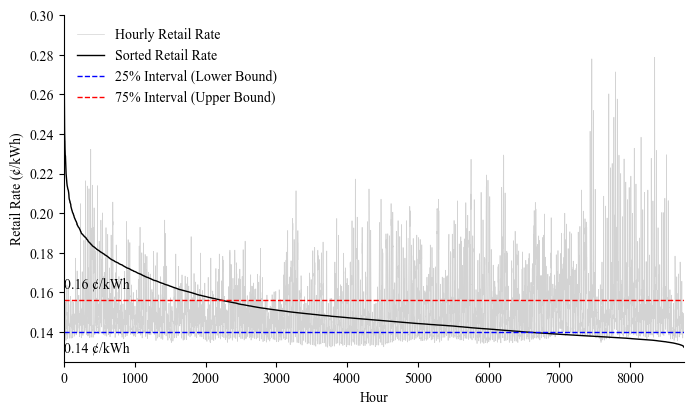

50% of prices are within: 0.14 cent to 0.16 cent


In [14]:
# Calculate average price and percentile bounds
average_price = np.mean(Retailer_VC[0, :])
lower_bound = np.percentile(Retailer_VC[0, :], 25)
upper_bound = np.percentile(Retailer_VC[0, :], 75)

plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Plot figure
plt.figure(figsize=(8, 4.5))

# Original load data (light gray line)
plt.plot(Retailer_VC[0, :], color='lightgray', linewidth=0.5, label='Hourly Retail Rate')

# Sorted load data (black line)
sorted_price_data = np.sort(Retailer_VC[0, :])[::-1]  # Sort in descending order
plt.plot(sorted_price_data, color='black', linewidth=1, label='Sorted Retail Rate')

# Plot 50% interval horizontal lines
plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='25% Interval (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='75% Interval (Upper Bound)')

# Adjust y-axis and x-axis limits
plt.ylim(0.125, 0.3)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(0, lower_bound - 0.008, f"{lower_bound:.2f} ¢/kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(0, upper_bound + 0.008, f"{upper_bound:.2f} ¢/kWh", va='center', ha='left', fontsize=10, color='black')

# Configure labels and legend
plt.xlabel("Hour")
plt.ylabel("Retail Rate (¢/kWh)")

# Update legend without box outline
legend = plt.legend(frameon=False)

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig("historical price.png", dpi=1200, bbox_inches='tight')

# Show plot
plt.show()


# Print 50% price interval range
print(f"50% of prices are within: {lower_bound:.2f} cent to {upper_bound:.2f} cent")


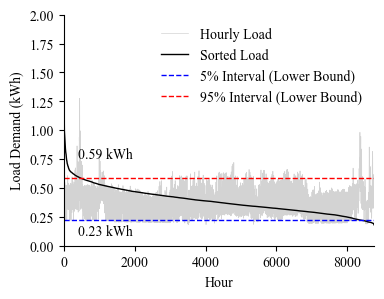

In [15]:
# 0
average_load = np.mean(Customerloadactual[:, 0])

lower_bound = np.percentile(Customerloadactual[:, 0], 5)
upper_bound = np.percentile(Customerloadactual[:, 0], 95)

plt.figure(figsize=(4, 3))

plt.plot(Customerloadactual[:, 0], color='lightgray', linewidth=0.5, label='Hourly Load')

sorted_load_data = np.sort(Customerloadactual[:, 0])[::-1]  
plt.plot(sorted_load_data, color='black', linewidth=1, label='Sorted Load')

plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='5% Interval (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='95% Interval (Lower Bound)')
plt.ylim(0, 2)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(400, lower_bound - 0.1, f"{lower_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(400, upper_bound + 0.2, f"{upper_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
         
plt.xlabel("Hour")
plt.ylabel("Load Demand (kWh)")
plt.legend()
legend = plt.legend(frameon=False)

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("output 0-1.png", dpi=1200, bbox_inches='tight')

plt.show()

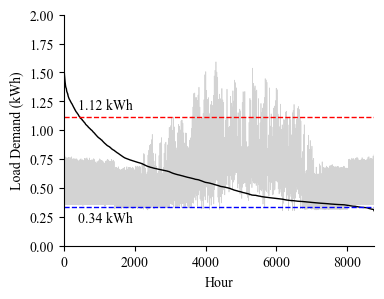

In [16]:
# 4
average_load = np.mean(Customerloadactual[:, 4])

lower_bound = np.percentile(Customerloadactual[:, 4], 5)
upper_bound = np.percentile(Customerloadactual[:, 4], 95)

plt.figure(figsize=(4, 3))

plt.plot(Customerloadactual[:, 4], color='lightgray', linewidth=0.5, label='Hourly Load')

sorted_load_data = np.sort(Customerloadactual[:, 4])[::-1]  # 按降序排序
plt.plot(sorted_load_data, color='black', linewidth=1, label='Sorted Load')

plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='5th Percentile (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='95th Percentile (Upper Bound)')
plt.ylim(0, 2)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(400, lower_bound - 0.1, f"{lower_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(400, upper_bound + 0.1, f"{upper_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
         
plt.xlabel("Hour")
plt.ylabel("Load Demand (kWh)")
#plt.legend()

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("output 4-1.png", dpi=1200, bbox_inches='tight')

plt.show()


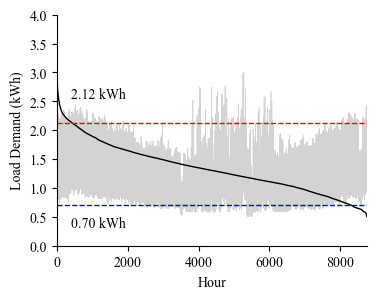

In [17]:
# 3
average_load = np.mean(Customerloadactual[:, 3])

lower_bound = np.percentile(Customerloadactual[:, 3], 5)
upper_bound = np.percentile(Customerloadactual[:, 3], 95)

plt.figure(figsize=(4, 3))

plt.plot(Customerloadactual[:, 3], color='lightgray', linewidth=0.5, label='Hourly Load')

sorted_load_data = np.sort(Customerloadactual[:, 3])[::-1] 
plt.plot(sorted_load_data, color='black', linewidth=1, label='Sorted Load')

plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='5th Percentile (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='95th Percentile (Upper Bound)')
plt.ylim(0, 4)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(400, lower_bound - 0.3, f"{lower_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(400, upper_bound + 0.5, f"{upper_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
         
plt.xlabel("Hour")
plt.ylabel("Load Demand (kWh)")
#plt.legend()

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("output 3-1.png", dpi=1200, bbox_inches='tight')

plt.show()

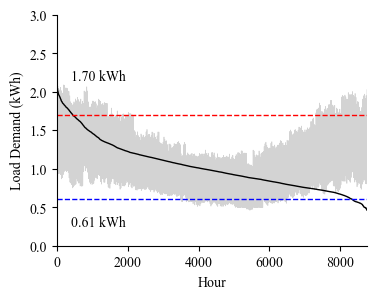

In [18]:
# 2
average_load = np.mean(Customerloadactual[:, 2])

lower_bound = np.percentile(Customerloadactual[:, 2], 5)
upper_bound = np.percentile(Customerloadactual[:, 2], 95)

plt.figure(figsize=(4, 3))

plt.plot(Customerloadactual[:, 2], color='lightgray', linewidth=0.5, label='Hourly Load')

sorted_load_data = np.sort(Customerloadactual[:, 2])[::-1]  # 按降序排序
plt.plot(sorted_load_data, color='black', linewidth=1, label='Sorted Load')

plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='5th Percentile (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='95th Percentile (Upper Bound)')
plt.ylim(0, 3)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(400, lower_bound - 0.3, f"{lower_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(400, upper_bound + 0.5, f"{upper_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
         
plt.xlabel("Hour")
plt.ylabel("Load Demand (kWh)")
#plt.legend()

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("output 2-1.png", dpi=1200, bbox_inches='tight')

plt.show()

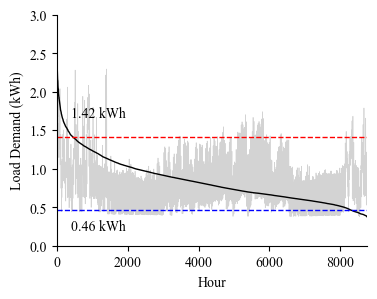

In [19]:
# 1
average_load = np.mean(Customerloadactual[:, 1])

lower_bound = np.percentile(Customerloadactual[:, 1], 5)
upper_bound = np.percentile(Customerloadactual[:, 1], 95)

plt.figure(figsize=(4, 3))

plt.plot(Customerloadactual[:, 1], color='lightgray', linewidth=0.5, label='Hourly Load')

sorted_load_data = np.sort(Customerloadactual[:, 1])[::-1]  
plt.plot(sorted_load_data, color='black', linewidth=1, label='Sorted Load')

# 绘制90%区间的水平线
plt.axhline(lower_bound, color='blue', linestyle='--', linewidth=1, label='5th Percentile (Lower Bound)')
plt.axhline(upper_bound, color='red', linestyle='--', linewidth=1, label='95th Percentile (Upper Bound)')
plt.ylim(0, 3)
plt.xlim(0, 8760)

# Add text tags aligned on the dashed lines to the left side
plt.text(400, lower_bound - 0.2, f"{lower_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
plt.text(400, upper_bound + 0.3, f"{upper_bound:.2f} kWh", va='center', ha='left', fontsize=10, color='black')
         
plt.xlabel("Hour")
plt.ylabel("Load Demand (kWh)")
#plt.legend()

# Turn off top and right edges
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("output 1-1.png", dpi=1200, bbox_inches='tight')

plt.show()